In [2]:
!pip install einops

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/29/0b/2d1c0ebfd092e25935b86509a9a817159212d82aa43d7fb07eca4eeff2c2/einops-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.1 MB/s eta 0:00:00


In [34]:
import torch
import cv2
import copy
import random
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from einops import rearrange
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        
        self.pre_quant_conv = nn.Conv2d(4, 2, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=2)
        self.post_quant_conv = nn.Conv2d(2, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        ## Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses



In [5]:
from torchvision import transforms

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

In [6]:
def train_vqvae():
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_loader = DataLoader(mnist, batch_size=64, shuffle=True, num_workers=4)
    
    best_loss = float('inf')
    model = VQVAE().to(device)
    
    num_epochs = 5
    optimizer = Adam(model.parameters(), lr=5E-4)
    criterion = torch.nn.MSELoss()
    
    for epoch_idx in range(num_epochs):
        train_loss = 0.0
        for im, label in tqdm(mnist_loader):
            im = im.float().to(device)
            optimizer.zero_grad()
            out, quantize_loss = model(im)
            
            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print('Finished epoch {}'.format(epoch_idx+1))
        print(f'Train loss: {train_loss:.4f}')
        
        # Save best model
        if train_loss < best_loss:
            best_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print('Best model so far')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print('Done Training...')
    return model

In [7]:
model = train_vqvae()

100%|██████████| 9912422/9912422 [00:00<00:00, 226352299.11it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47691218.04it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 61784335.66it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6914892.47it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 938/938 [00:08<00:00, 114.76it/s]


Finished epoch 1
Train loss: 230.5537
Best model so far


100%|██████████| 938/938 [00:06<00:00, 136.46it/s]


Finished epoch 2
Train loss: 106.5223
Best model so far


100%|██████████| 938/938 [00:06<00:00, 138.53it/s]


Finished epoch 3
Train loss: 101.5977
Best model so far


100%|██████████| 938/938 [00:06<00:00, 136.42it/s]


Finished epoch 4
Train loss: 104.9879


100%|██████████| 938/938 [00:06<00:00, 136.92it/s]

Finished epoch 5
Train loss: 114.7563
Done Training...


In [8]:
def plot_emb(embdd_vec,data):
    
    fig , ax = plt.subplots(figsize=(5,7), dpi=150)
    plt.scatter(data[:,0],data[:,1] , s=5 , color = 'black')
    
    # Plot embedded vector
    plt.scatter(embdd_vec[:,0],embdd_vec[:,1],s=30 , color = 'red')
    
    n = ['e1','e2','e3']
    for i, txt in enumerate(n):
        ax.annotate(txt, (embdd_vec[i,0], embdd_vec[i,1]),color = 'red',fontsize=15)
    # Add labels
    plt.xlabel('x values')
    plt.ylabel('y values')

    # Add title  
    plt.title('Scatter Plot') 


    # Add grid lines
    plt.grid(linestyle='--', linewidth=1) 

    
    plt.show()
    plt.close('all')

    return fig

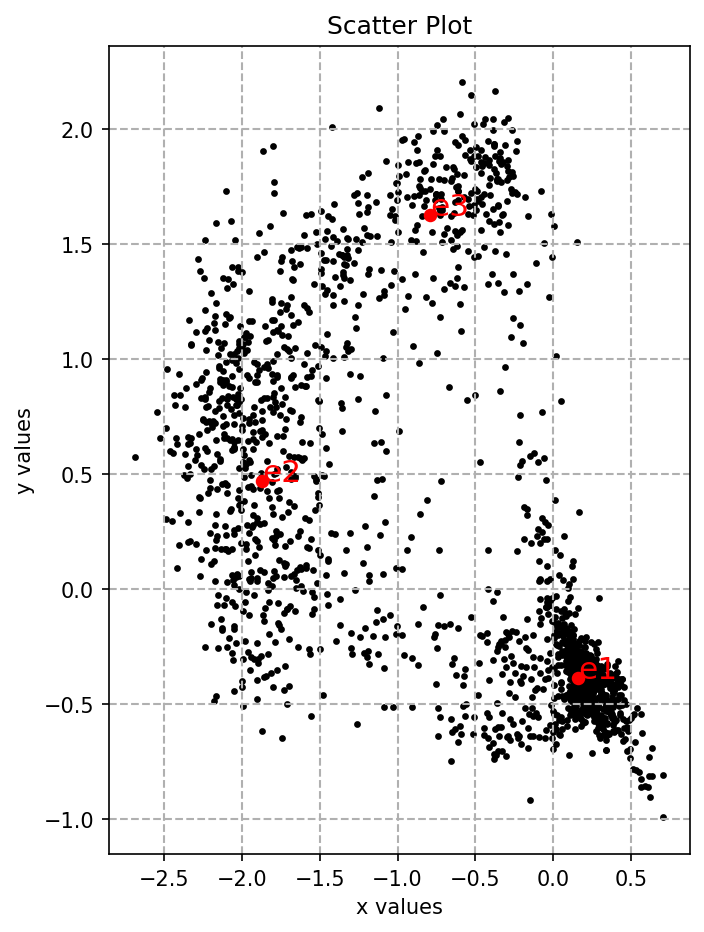

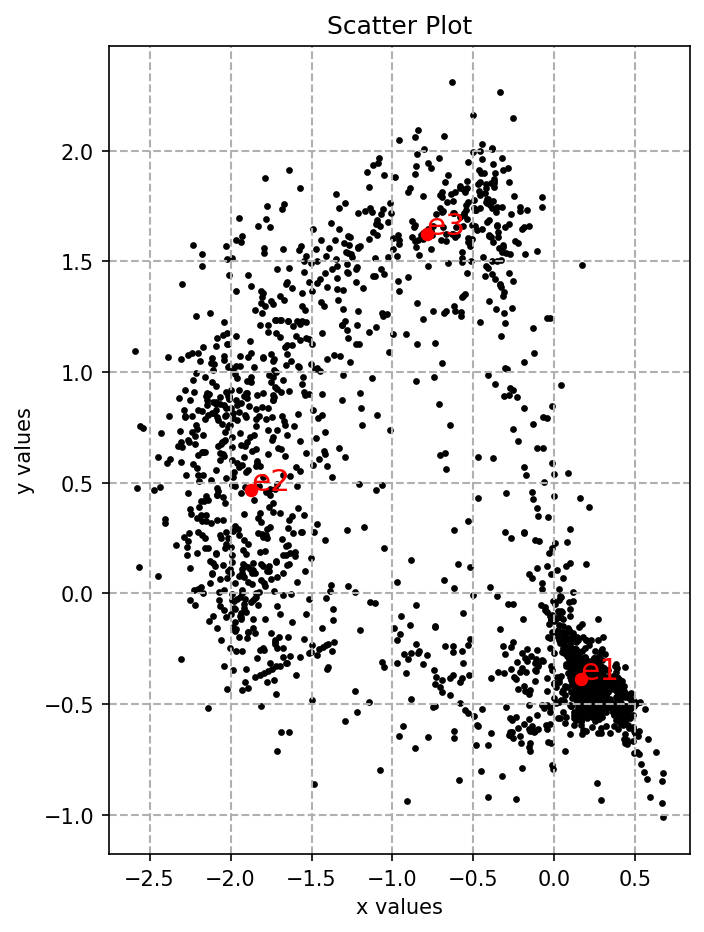

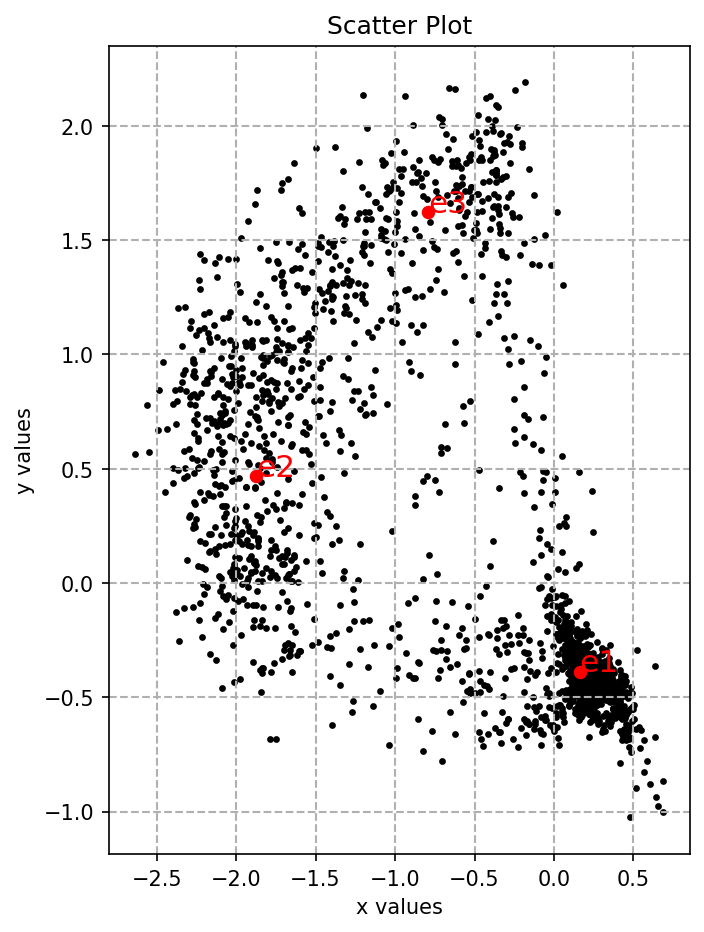

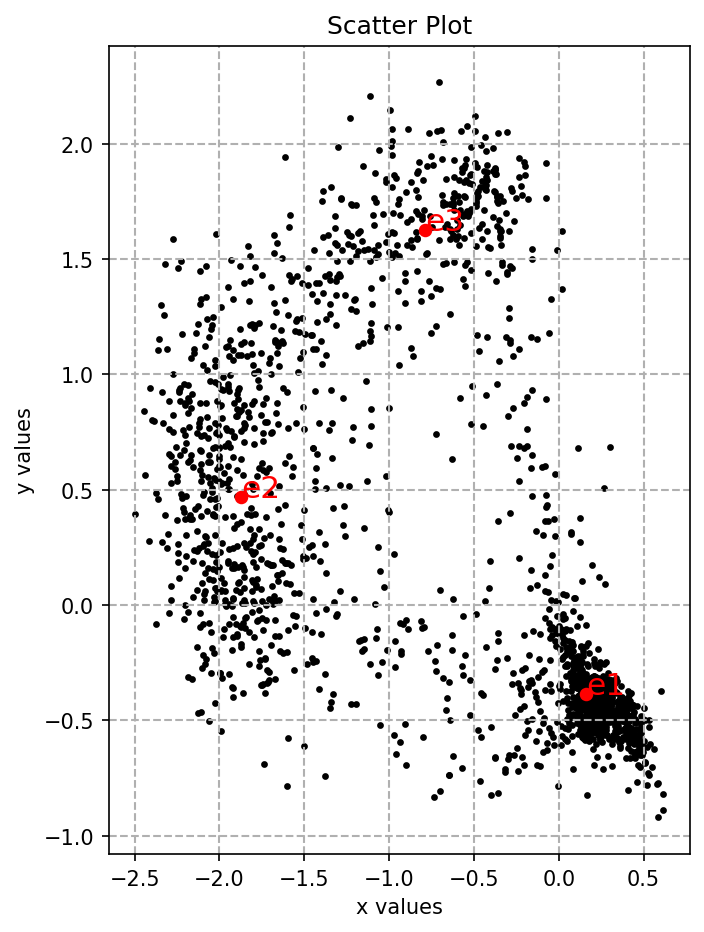

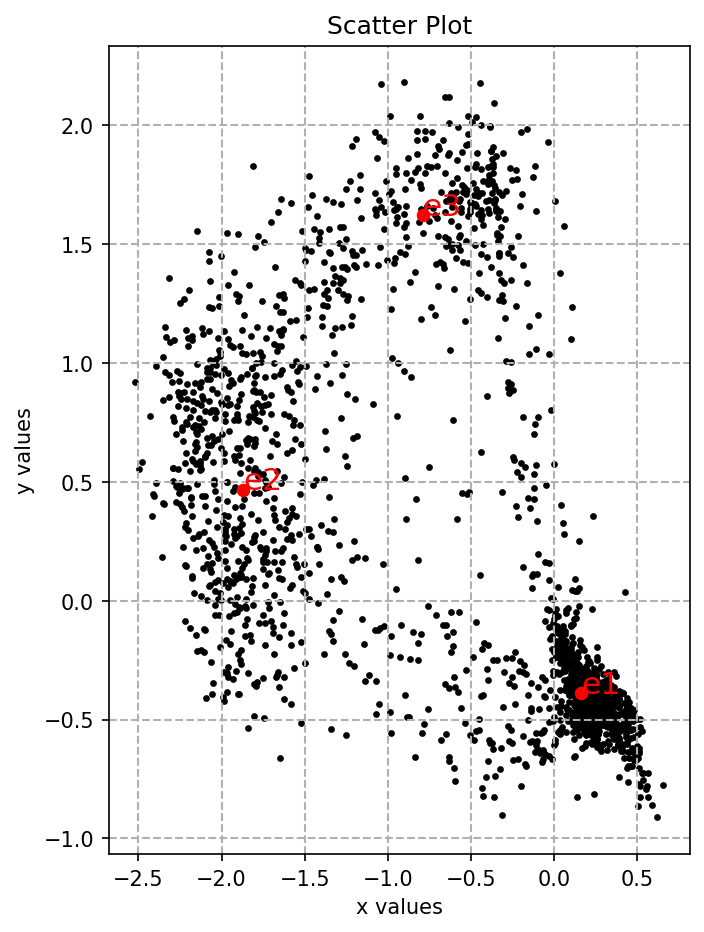

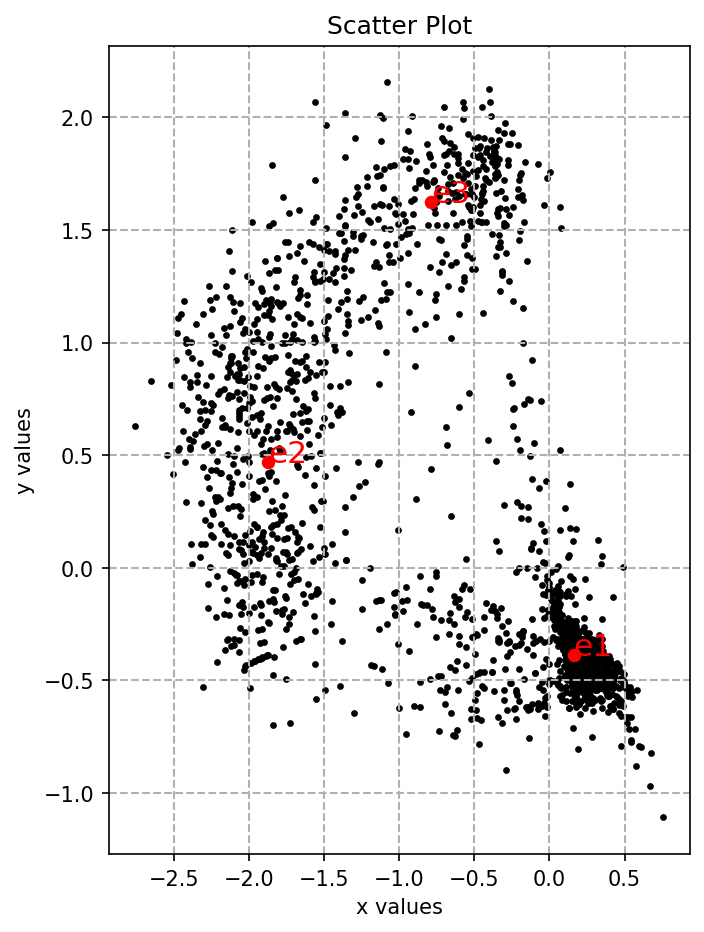

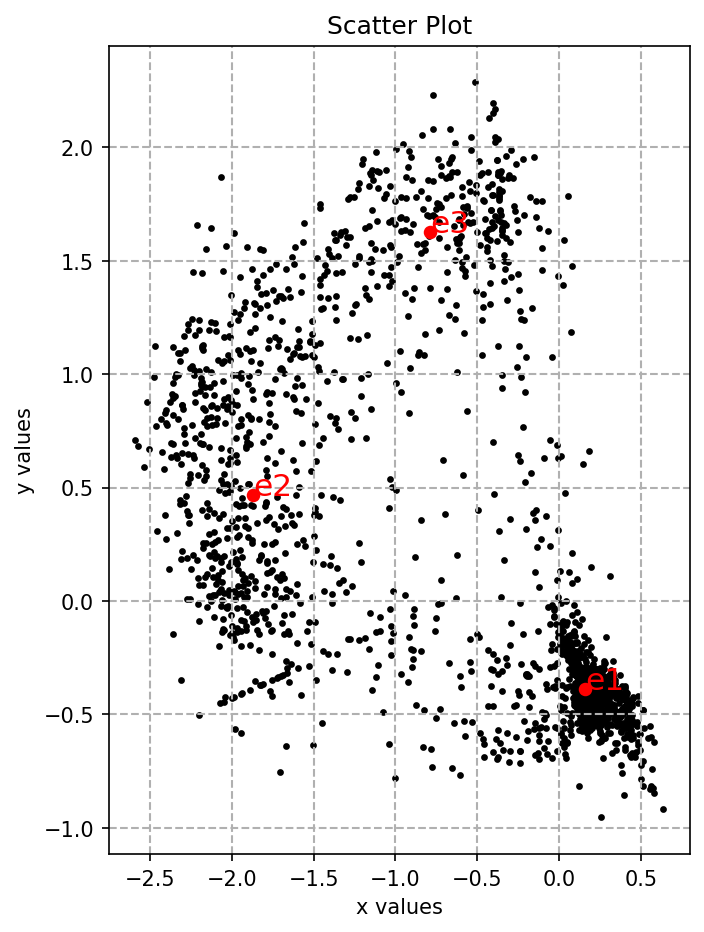

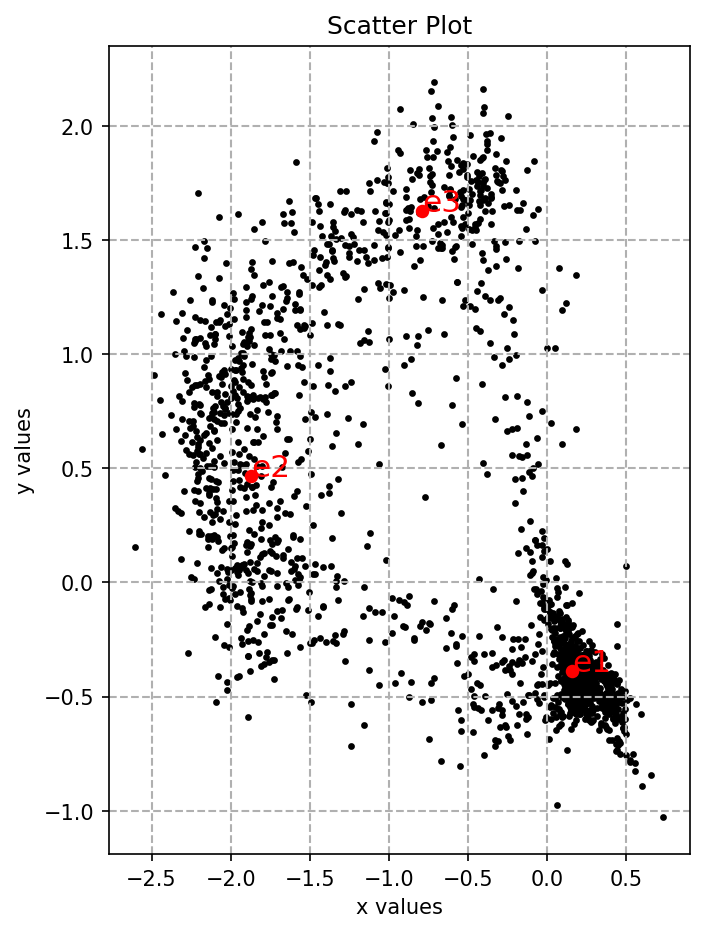

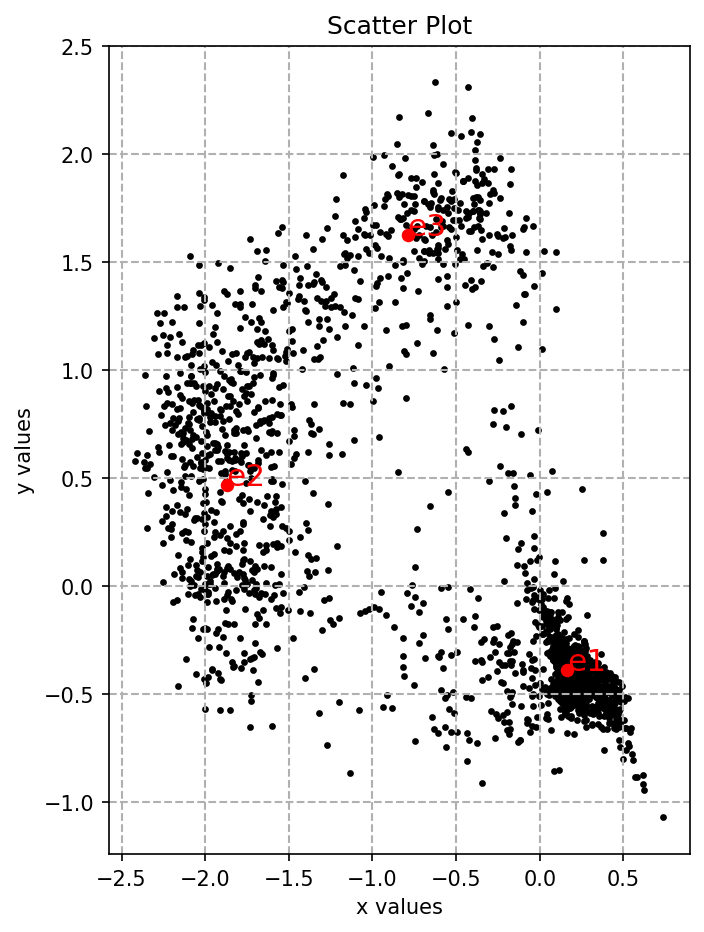

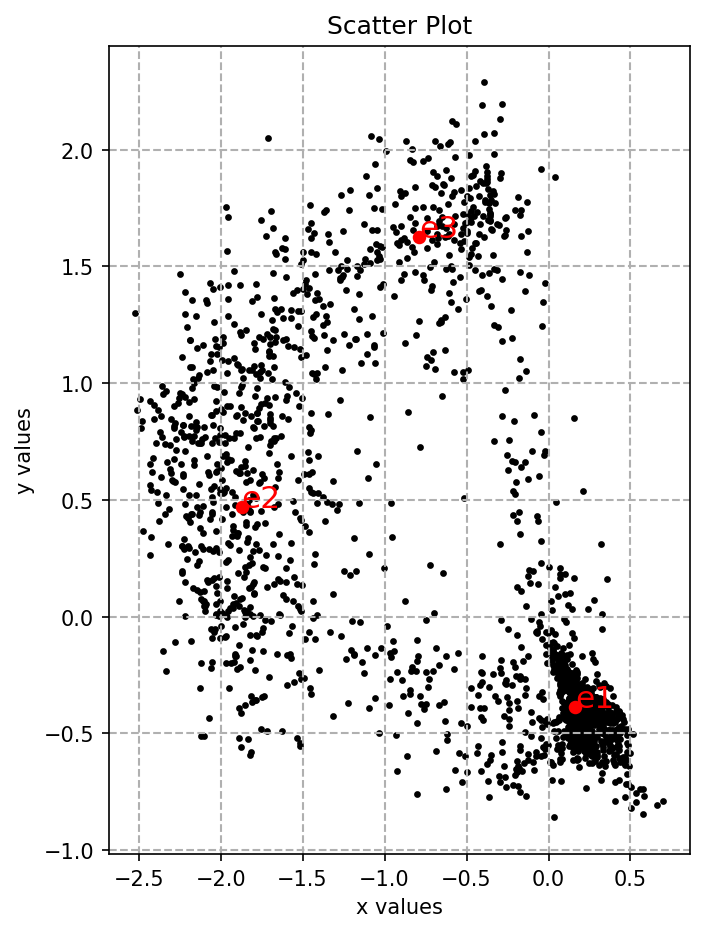

In [9]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=4)

newpath = r'/kaggle/working/data/images' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
filesname = []
for i in range(10):
    im,label = next(iter(test_loader))
    im = im.float().to(device)
    vectors = model.pre_quant_conv(model.encoder(im)).detach().cpu()
    quant_input = vectors.permute(0, 2, 3, 1)
    quant_input = quant_input.reshape(( -1, quant_input.size(-1)))
    t = model.embedding.weight[None, :].detach().cpu().numpy().reshape(3,2)
    fig = plot_emb(t,quant_input)
    
    filename = f'/kaggle/working/data/images/figure {i+1}.png'          
    filesname.append(filename)
    fig.savefig(filename, bbox_inches='tight')

In [10]:
filesname

['/kaggle/working/data/images/figure 1.png',
 '/kaggle/working/data/images/figure 2.png',
 '/kaggle/working/data/images/figure 3.png',
 '/kaggle/working/data/images/figure 4.png',
 '/kaggle/working/data/images/figure 5.png',
 '/kaggle/working/data/images/figure 6.png',
 '/kaggle/working/data/images/figure 7.png',
 '/kaggle/working/data/images/figure 8.png',
 '/kaggle/working/data/images/figure 9.png',
 '/kaggle/working/data/images/figure 10.png']

In [11]:
import imageio
# create the animation (.gif)!!!
with imageio.get_writer('myAnimation.gif', duration=100) as writer:   
    for filename in filesname:
        image = imageio.imread(filename)                         
        writer.append_data(image)                                
print('Gif saved!\n')

/tmp/ipykernel_26/815382446.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Gif saved!



In [12]:
# Reconstruction part
    
idxs = torch.randint(0, len(mnist_test), (100, ))
ims = torch.cat([mnist_test[idx][0][None, :] for idx in idxs]).float()
ims = ims.to(device)
model.eval()
    
    
generated_im, _ = model(ims)
ims = (ims+1)/2
generated_im = 1 - (generated_im+1)/2
out = torch.hstack([ims, generated_im])
output = rearrange(out, 'b c h w -> b () h (c w)')
grid = torchvision.utils.make_grid(output.detach().cpu(), nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
img.save('reconstruction.png')
    
print('Done Reconstruction ...')

Done Reconstruction ...


In [13]:
class VQVAE2(nn.Module):
    def __init__(self,embedded_size,embedded_dim):
        super(VQVAE2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        
        self.pre_quant_conv = nn.Conv2d(4, embedded_dim, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=embedded_size, embedding_dim=embedded_dim)
        self.post_quant_conv = nn.Conv2d(embedded_dim, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        ## Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses



In [14]:
model = VQVAE2(embedded_size=10,embedded_dim=4).to(device)
x = torch.randn(64,3,28,28).to(device)
print(model(x)[0].shape)

torch.Size([64, 3, 28, 28])


In [24]:
im, label = next(iter(test_loader))
im = im.float().to(device)
input = torch.empty(64,3,28,28)
input = torch.cat((im.reshape(64,1,28,28),im.reshape(64,1,28,28),im.reshape(64,1,28,28)),1)
print(input.shape)

torch.Size([64, 3, 28, 28])


In [196]:
num1 = torch.rand(64).to(device)
num2 = torch.rand(64).to(device)
num3 = torch.rand(64).to(device)
print((num1[:, None, None, None] * im.reshape(64,1,28,28)).shape)

torch.Size([64, 1, 28, 28])


torch.Size([28, 28, 3])


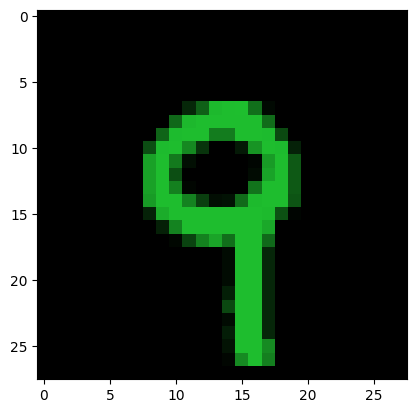

In [213]:
im, label = next(iter(test_loader))
im = im.float().to(device)
input = torch.empty(64,3,28,28)
input = torch.cat((num1[:, None, None, None] * im.reshape(64,1,28,28),
                   num2[:, None, None, None] * im.reshape(64,1,28,28),
                   num3[:, None, None, None] * im.reshape(64,1,28,28)),1).permute(0,2,3,1)
print(input[1].shape)
plt.imshow(input[6].cpu())

Everything's GO0O0O0O0D

In [250]:
def train_vqvae2(embedded_size,embedded_dim,epochs=10):
    batch_size =64
    channel_size=3
    mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True, num_workers=4)
    
    best_loss = float('inf')
    model = VQVAE2(embedded_size=embedded_size,embedded_dim=embedded_dim).to(device)
    
    num_epochs = epochs
    optimizer = Adam(model.parameters(), lr=5E-4)
    criterion = torch.nn.MSELoss()
    
    for epoch_idx in range(num_epochs):
        train_loss = 0.0
        for im, label in tqdm(mnist_loader):
            im = im.float().to(device)
            num1 = torch.rand(im.size(0)).to(device)
            num2 = torch.rand(im.size(0)).to(device)
            num3 = torch.rand(im.size(0)).to(device)
            input = torch.empty(64,3,28,28)
            input = torch.cat((num1[:, None, None, None] * im.reshape(im.size(0),1,28,28),
                               num2[:, None, None, None] * im.reshape(im.size(0),1,28,28),
                               num3[:, None, None, None] * im.reshape(im.size(0),1,28,28)),1)
            optimizer.zero_grad()
            out, quantize_loss = model(input)
            
            recon_loss = criterion(out, input)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print('Finished epoch {}'.format(epoch_idx+1))
        print(f'Train loss: {train_loss:.4f}')
        
        # Save best model
        if train_loss < best_loss:
            best_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print('Best model so far')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print('Done Training...')
    return model,best_loss

In [251]:
(model , loss) = train_vqvae2(epochs=40,embedded_size=20,embedded_dim=5)

100%|██████████| 938/938 [00:07<00:00, 119.08it/s]


Finished epoch 1
Train loss: 46.1640
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.78it/s]


Finished epoch 2
Train loss: 24.8609
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.22it/s]


Finished epoch 3
Train loss: 27.7954


100%|██████████| 938/938 [00:07<00:00, 126.87it/s]


Finished epoch 4
Train loss: 26.2000


100%|██████████| 938/938 [00:07<00:00, 120.33it/s]


Finished epoch 5
Train loss: 22.0489
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.66it/s]


Finished epoch 6
Train loss: 21.3401
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.33it/s]


Finished epoch 7
Train loss: 21.3008
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.85it/s]


Finished epoch 8
Train loss: 21.1636
Best model so far


100%|██████████| 938/938 [00:07<00:00, 119.78it/s]


Finished epoch 9
Train loss: 20.5892
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.41it/s]


Finished epoch 10
Train loss: 20.1592
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.35it/s]


Finished epoch 11
Train loss: 19.8812
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.40it/s]


Finished epoch 12
Train loss: 19.8424
Best model so far


100%|██████████| 938/938 [00:07<00:00, 121.24it/s]


Finished epoch 13
Train loss: 19.8476


100%|██████████| 938/938 [00:07<00:00, 124.38it/s]


Finished epoch 14
Train loss: 19.7287
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.85it/s]


Finished epoch 15
Train loss: 19.6442
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.70it/s]


Finished epoch 16
Train loss: 19.7334


100%|██████████| 938/938 [00:07<00:00, 124.45it/s]


Finished epoch 17
Train loss: 19.7039


100%|██████████| 938/938 [00:07<00:00, 121.40it/s]


Finished epoch 18
Train loss: 19.6787


100%|██████████| 938/938 [00:07<00:00, 125.62it/s]


Finished epoch 19
Train loss: 19.7692


100%|██████████| 938/938 [00:07<00:00, 125.23it/s]


Finished epoch 20
Train loss: 19.7334


100%|██████████| 938/938 [00:07<00:00, 125.15it/s]


Finished epoch 21
Train loss: 19.7424


100%|██████████| 938/938 [00:07<00:00, 121.15it/s]


Finished epoch 22
Train loss: 19.6945


100%|██████████| 938/938 [00:07<00:00, 125.07it/s]


Finished epoch 23
Train loss: 19.7688


100%|██████████| 938/938 [00:07<00:00, 124.38it/s]


Finished epoch 24
Train loss: 19.7652


100%|██████████| 938/938 [00:07<00:00, 123.81it/s]


Finished epoch 25
Train loss: 19.7192


100%|██████████| 938/938 [00:07<00:00, 120.86it/s]


Finished epoch 26
Train loss: 19.8394


100%|██████████| 938/938 [00:07<00:00, 126.69it/s]


Finished epoch 27
Train loss: 19.9082


100%|██████████| 938/938 [00:07<00:00, 126.64it/s]


Finished epoch 28
Train loss: 19.8858


100%|██████████| 938/938 [00:07<00:00, 126.77it/s]


Finished epoch 29
Train loss: 19.8282


100%|██████████| 938/938 [00:07<00:00, 120.80it/s]


Finished epoch 30
Train loss: 19.8972


100%|██████████| 938/938 [00:07<00:00, 125.15it/s]


Finished epoch 31
Train loss: 19.9807


100%|██████████| 938/938 [00:07<00:00, 125.15it/s]


Finished epoch 32
Train loss: 20.2056


100%|██████████| 938/938 [00:07<00:00, 124.83it/s]


Finished epoch 33
Train loss: 20.0397


100%|██████████| 938/938 [00:07<00:00, 121.73it/s]


Finished epoch 34
Train loss: 19.6830


100%|██████████| 938/938 [00:07<00:00, 123.94it/s]


Finished epoch 35
Train loss: 19.9047


100%|██████████| 938/938 [00:07<00:00, 125.51it/s]


Finished epoch 36
Train loss: 20.0650


100%|██████████| 938/938 [00:07<00:00, 125.70it/s]


Finished epoch 37
Train loss: 20.2056


100%|██████████| 938/938 [00:07<00:00, 124.80it/s]


Finished epoch 38
Train loss: 20.4776


100%|██████████| 938/938 [00:07<00:00, 121.61it/s]


Finished epoch 39
Train loss: 20.6611


100%|██████████| 938/938 [00:07<00:00, 124.85it/s]

Finished epoch 40
Train loss: 20.7843
Done Training...


In [ ]:
# Reconstruction part
    
idxs = torch.randint(0, len(mnist_test), (100, ))
ims = torch.cat([mnist_test[idx][0][None, :] for idx in idxs]).float()
input = torch.cat((num1[:, None, None, None] * im.reshape(64,1,28,28),
                   num2[:, None, None, None] * im.reshape(64,1,28,28),
                   num3[:, None, None, None] * im.reshape(64,1,28,28)),1)
input = input.to(device)
model.eval()
    
    
(generated_im, _) = model(input)
input = (input+1)/2
generated_im = 1 - (generated_im+1)/2
out = generated_im
output = rearrange(out, 'b c h w -> b c h w')
grid = torchvision.utils.make_grid(output.detach().cpu(), nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
img.save('reconstruction2.png')

print(generated_im[0].shape)
print(generated_im[34,:,1,1])
plt.imshow(generated_im.detach().cpu()[42].permute(1,2,0))
# plt.imshow(generated_im.detach().cpu()[3].permute(1,2,0))
print('Done Reconstruction ...')

In [100]:
losses = []
for i in (5,10,20,30,40,50):
    (model , loss) = train_vqvae2(i,2)
    losses.append(loss)

100%|██████████| 938/938 [00:07<00:00, 122.60it/s]


Finished epoch 1
Train loss: 126.5638
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.49it/s]


Finished epoch 2
Train loss: 32.5360
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.59it/s]


Finished epoch 3
Train loss: 28.3953
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.46it/s]


Finished epoch 4
Train loss: 26.3791
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.65it/s]


Finished epoch 5
Train loss: 28.0286


100%|██████████| 938/938 [00:07<00:00, 121.80it/s]


Finished epoch 6
Train loss: 27.1270


100%|██████████| 938/938 [00:07<00:00, 125.05it/s]


Finished epoch 7
Train loss: 27.4439


100%|██████████| 938/938 [00:07<00:00, 125.15it/s]


Finished epoch 8
Train loss: 25.8737
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.84it/s]


Finished epoch 9
Train loss: 25.1189
Best model so far


100%|██████████| 938/938 [00:07<00:00, 121.54it/s]


Finished epoch 10
Train loss: 22.6046
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 125.28it/s]


Finished epoch 1
Train loss: 35.3277
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.53it/s]


Finished epoch 2
Train loss: 24.3474
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.10it/s]


Finished epoch 3
Train loss: 24.7151


100%|██████████| 938/938 [00:07<00:00, 120.69it/s]


Finished epoch 4
Train loss: 25.6532


100%|██████████| 938/938 [00:07<00:00, 127.21it/s]


Finished epoch 5
Train loss: 27.6646


100%|██████████| 938/938 [00:07<00:00, 126.17it/s]


Finished epoch 6
Train loss: 28.1041


100%|██████████| 938/938 [00:07<00:00, 126.32it/s]


Finished epoch 7
Train loss: 27.7520


100%|██████████| 938/938 [00:07<00:00, 123.71it/s]


Finished epoch 8
Train loss: 28.5292


100%|██████████| 938/938 [00:07<00:00, 126.32it/s]


Finished epoch 9
Train loss: 26.4060


100%|██████████| 938/938 [00:07<00:00, 125.09it/s]


Finished epoch 10
Train loss: 23.7946
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 124.76it/s]


Finished epoch 1
Train loss: 36.2163
Best model so far


100%|██████████| 938/938 [00:07<00:00, 121.38it/s]


Finished epoch 2
Train loss: 24.5106
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.34it/s]


Finished epoch 3
Train loss: 23.2681
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.48it/s]


Finished epoch 4
Train loss: 20.1886
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.76it/s]


Finished epoch 5
Train loss: 18.7770
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.64it/s]


Finished epoch 6
Train loss: 17.1639
Best model so far


100%|██████████| 938/938 [00:07<00:00, 121.73it/s]


Finished epoch 7
Train loss: 16.7159
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.23it/s]


Finished epoch 8
Train loss: 16.7678


100%|██████████| 938/938 [00:07<00:00, 126.97it/s]


Finished epoch 9
Train loss: 15.9519
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.40it/s]


Finished epoch 10
Train loss: 15.4273
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 121.56it/s]


Finished epoch 1
Train loss: 27.1915
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.03it/s]


Finished epoch 2
Train loss: 20.4782
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.80it/s]


Finished epoch 3
Train loss: 19.6530
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.06it/s]


Finished epoch 4
Train loss: 19.5542
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.24it/s]


Finished epoch 5
Train loss: 19.4958
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.32it/s]


Finished epoch 6
Train loss: 19.4259
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.88it/s]


Finished epoch 7
Train loss: 19.0505
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.67it/s]


Finished epoch 8
Train loss: 18.6735
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.23it/s]


Finished epoch 9
Train loss: 18.0949
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.02it/s]


Finished epoch 10
Train loss: 18.0878
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 125.01it/s]


Finished epoch 1
Train loss: 28.7048
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.78it/s]


Finished epoch 2
Train loss: 18.4308
Best model so far


100%|██████████| 938/938 [00:07<00:00, 122.68it/s]


Finished epoch 3
Train loss: 16.6385
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.63it/s]


Finished epoch 4
Train loss: 16.2433
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.90it/s]


Finished epoch 5
Train loss: 16.0734
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.09it/s]


Finished epoch 6
Train loss: 16.0952


100%|██████████| 938/938 [00:07<00:00, 126.54it/s]


Finished epoch 7
Train loss: 15.5549
Best model so far


100%|██████████| 938/938 [00:07<00:00, 120.74it/s]


Finished epoch 8
Train loss: 15.4911
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.23it/s]


Finished epoch 9
Train loss: 15.5652


100%|██████████| 938/938 [00:07<00:00, 128.98it/s]


Finished epoch 10
Train loss: 15.3076
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 126.81it/s]


Finished epoch 1
Train loss: 25.1994
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.56it/s]


Finished epoch 2
Train loss: 17.8827
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.81it/s]


Finished epoch 3
Train loss: 17.0150
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.26it/s]


Finished epoch 4
Train loss: 16.0769
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.57it/s]


Finished epoch 5
Train loss: 15.3455
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.88it/s]


Finished epoch 6
Train loss: 15.0366
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.58it/s]


Finished epoch 7
Train loss: 14.9305
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.46it/s]


Finished epoch 8
Train loss: 15.0424


100%|██████████| 938/938 [00:07<00:00, 126.48it/s]


Finished epoch 9
Train loss: 14.3478
Best model so far


100%|██████████| 938/938 [00:07<00:00, 121.01it/s]

Finished epoch 10
Train loss: 14.1659
Best model so far
Done Training...


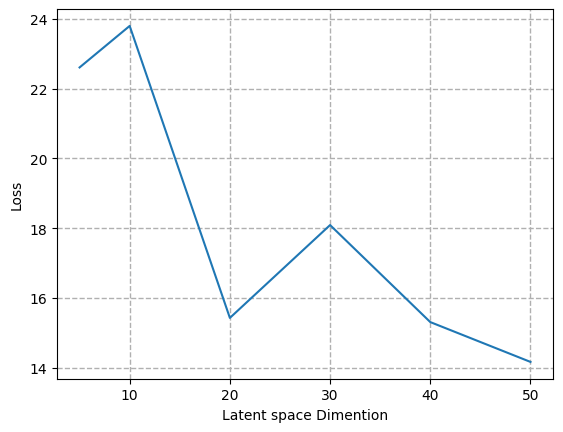

In [104]:
x = (5,10,20,30,40,50)
plt.plot(x,losses)

plt.xlabel('Latent space Dimention')
plt.ylabel('Loss')
plt.grid(linestyle='--', linewidth=1) 

In [105]:
losses = []
for i in (5,10,20,30,40,50):
    (model , loss) = train_vqvae2(3,i)
    losses.append(loss)

100%|██████████| 938/938 [00:07<00:00, 130.61it/s]


Finished epoch 1
Train loss: 213.3825
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.62it/s]


Finished epoch 2
Train loss: 61.2366
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.64it/s]


Finished epoch 3
Train loss: 56.7018
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.15it/s]


Finished epoch 4
Train loss: 54.8172
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.29it/s]


Finished epoch 5
Train loss: 52.1352
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.97it/s]


Finished epoch 6
Train loss: 48.1403
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.71it/s]


Finished epoch 7
Train loss: 46.4134
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.13it/s]


Finished epoch 8
Train loss: 45.3212
Best model so far


100%|██████████| 938/938 [00:07<00:00, 130.50it/s]


Finished epoch 9
Train loss: 45.8172


100%|██████████| 938/938 [00:07<00:00, 126.66it/s]


Finished epoch 10
Train loss: 47.1000
Done Training...


100%|██████████| 938/938 [00:07<00:00, 128.33it/s]


Finished epoch 1
Train loss: 238.2788
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.28it/s]


Finished epoch 2
Train loss: 49.1872
Best model so far


100%|██████████| 938/938 [00:07<00:00, 124.81it/s]


Finished epoch 3
Train loss: 37.5544
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.52it/s]


Finished epoch 4
Train loss: 34.6638
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.89it/s]


Finished epoch 5
Train loss: 34.9707


100%|██████████| 938/938 [00:07<00:00, 130.00it/s]


Finished epoch 6
Train loss: 36.6101


100%|██████████| 938/938 [00:07<00:00, 125.52it/s]


Finished epoch 7
Train loss: 36.2035


100%|██████████| 938/938 [00:07<00:00, 132.48it/s]


Finished epoch 8
Train loss: 34.9955


100%|██████████| 938/938 [00:07<00:00, 129.49it/s]


Finished epoch 9
Train loss: 36.5630


100%|██████████| 938/938 [00:07<00:00, 127.65it/s]


Finished epoch 10
Train loss: 36.1522
Done Training...


100%|██████████| 938/938 [00:07<00:00, 122.67it/s]


Finished epoch 1
Train loss: 398.0013
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.81it/s]


Finished epoch 2
Train loss: 243.2461
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.41it/s]


Finished epoch 3
Train loss: 202.6785
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.17it/s]


Finished epoch 4
Train loss: 163.2225
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.16it/s]


Finished epoch 5
Train loss: 132.0999
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.73it/s]


Finished epoch 6
Train loss: 119.9111
Best model so far


100%|██████████| 938/938 [00:07<00:00, 130.46it/s]


Finished epoch 7
Train loss: 108.8384
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.56it/s]


Finished epoch 8
Train loss: 94.7805
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.68it/s]


Finished epoch 9
Train loss: 84.5258
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.97it/s]


Finished epoch 10
Train loss: 75.2254
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 128.81it/s]


Finished epoch 1
Train loss: 363.7801
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.07it/s]


Finished epoch 2
Train loss: 82.4872
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.39it/s]


Finished epoch 3
Train loss: 69.8222
Best model so far


100%|██████████| 938/938 [00:07<00:00, 125.69it/s]


Finished epoch 4
Train loss: 68.5662
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.33it/s]


Finished epoch 5
Train loss: 62.1379
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.58it/s]


Finished epoch 6
Train loss: 59.4338
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.67it/s]


Finished epoch 7
Train loss: 55.9508
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.45it/s]


Finished epoch 8
Train loss: 57.2529


100%|██████████| 938/938 [00:07<00:00, 125.34it/s]


Finished epoch 9
Train loss: 53.3546
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.18it/s]


Finished epoch 10
Train loss: 51.8670
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 127.49it/s]


Finished epoch 1
Train loss: 438.0402
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.75it/s]


Finished epoch 2
Train loss: 154.6618
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.59it/s]


Finished epoch 3
Train loss: 128.6690
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.71it/s]


Finished epoch 4
Train loss: 106.6811
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.81it/s]


Finished epoch 5
Train loss: 93.3216
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.55it/s]


Finished epoch 6
Train loss: 81.0990
Best model so far


100%|██████████| 938/938 [00:07<00:00, 122.74it/s]


Finished epoch 7
Train loss: 74.0787
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.44it/s]


Finished epoch 8
Train loss: 66.0545
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.14it/s]


Finished epoch 9
Train loss: 64.4105
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.52it/s]


Finished epoch 10
Train loss: 59.0216
Best model so far
Done Training...


100%|██████████| 938/938 [00:07<00:00, 124.20it/s]


Finished epoch 1
Train loss: 411.4713
Best model so far


100%|██████████| 938/938 [00:07<00:00, 126.95it/s]


Finished epoch 2
Train loss: 68.1770
Best model so far


100%|██████████| 938/938 [00:07<00:00, 128.37it/s]


Finished epoch 3
Train loss: 58.3382
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.67it/s]


Finished epoch 4
Train loss: 54.8006
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.04it/s]


Finished epoch 5
Train loss: 49.1889
Best model so far


100%|██████████| 938/938 [00:07<00:00, 123.97it/s]


Finished epoch 6
Train loss: 45.1771
Best model so far


100%|██████████| 938/938 [00:07<00:00, 129.44it/s]


Finished epoch 7
Train loss: 41.9285
Best model so far


100%|██████████| 938/938 [00:07<00:00, 127.42it/s]


Finished epoch 8
Train loss: 41.0336
Best model so far


100%|██████████| 938/938 [00:07<00:00, 130.12it/s]


Finished epoch 9
Train loss: 41.0741


100%|██████████| 938/938 [00:07<00:00, 125.23it/s]

Finished epoch 10
Train loss: 38.9961
Best model so far
Done Training...


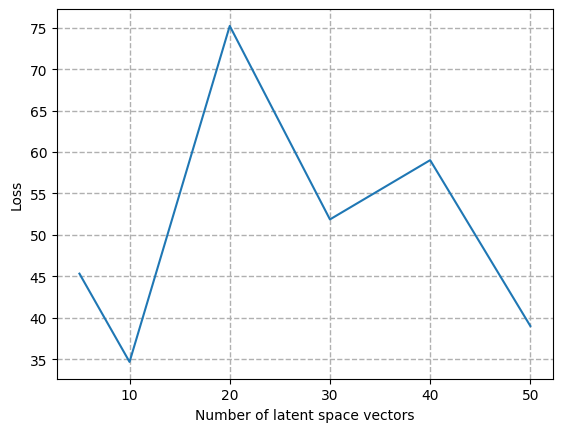

In [107]:
x = (5,10,20,30,40,50)
plt.plot(x,losses)

plt.xlabel('Number of latent space vectors')
plt.ylabel('Loss')
plt.grid(linestyle='--', linewidth=1) 